In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn import ensemble, preprocessing, tree, model_selection, feature_selection, pipeline, metrics
from imblearn import under_sampling, over_sampling, combine
from imblearn import pipeline as imb_pipeline
from imblearn import ensemble as imb_ensemble
from sklearn.model_selection import StratifiedKFold
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from skopt import gp_minimize, space, gbrt_minimize, dummy_minimize, forest_minimize
from functools import partial
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/av-janatahack-machine-learning-in-agriculture/test_pFkWwen.csv
/kaggle/input/av-janatahack-machine-learning-in-agriculture/sample_submission_O1oDc4H.csv
/kaggle/input/av-janatahack-machine-learning-in-agriculture/train_yaOffsB.csv


In [2]:
train = pd.read_csv('/kaggle/input/av-janatahack-machine-learning-in-agriculture/train_yaOffsB.csv')
test = pd.read_csv('/kaggle/input/av-janatahack-machine-learning-in-agriculture/test_pFkWwen.csv')

In [3]:
cols = ['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type',
       'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used',
       'Number_Weeks_Quit', 'Season', 'Crop_Damage']

In [4]:
fill_values = train.median()
train = train.fillna(fill_values)
test = test.fillna(fill_values)

In [5]:
# Try log transform on features which appear skewed
def preprocess(data):
    data['Estimated_Insects_Count'] = np.log1p(data['Estimated_Insects_Count'].values)
    data['Number_Weeks_Quit'] = np.log1p(data['Number_Weeks_Quit'].values)
    #data['Number_Weeks_Used'] = np.log1p(data['Number_Weeks_Used'].values)
    return data

train = preprocess(train)
test = preprocess(test)

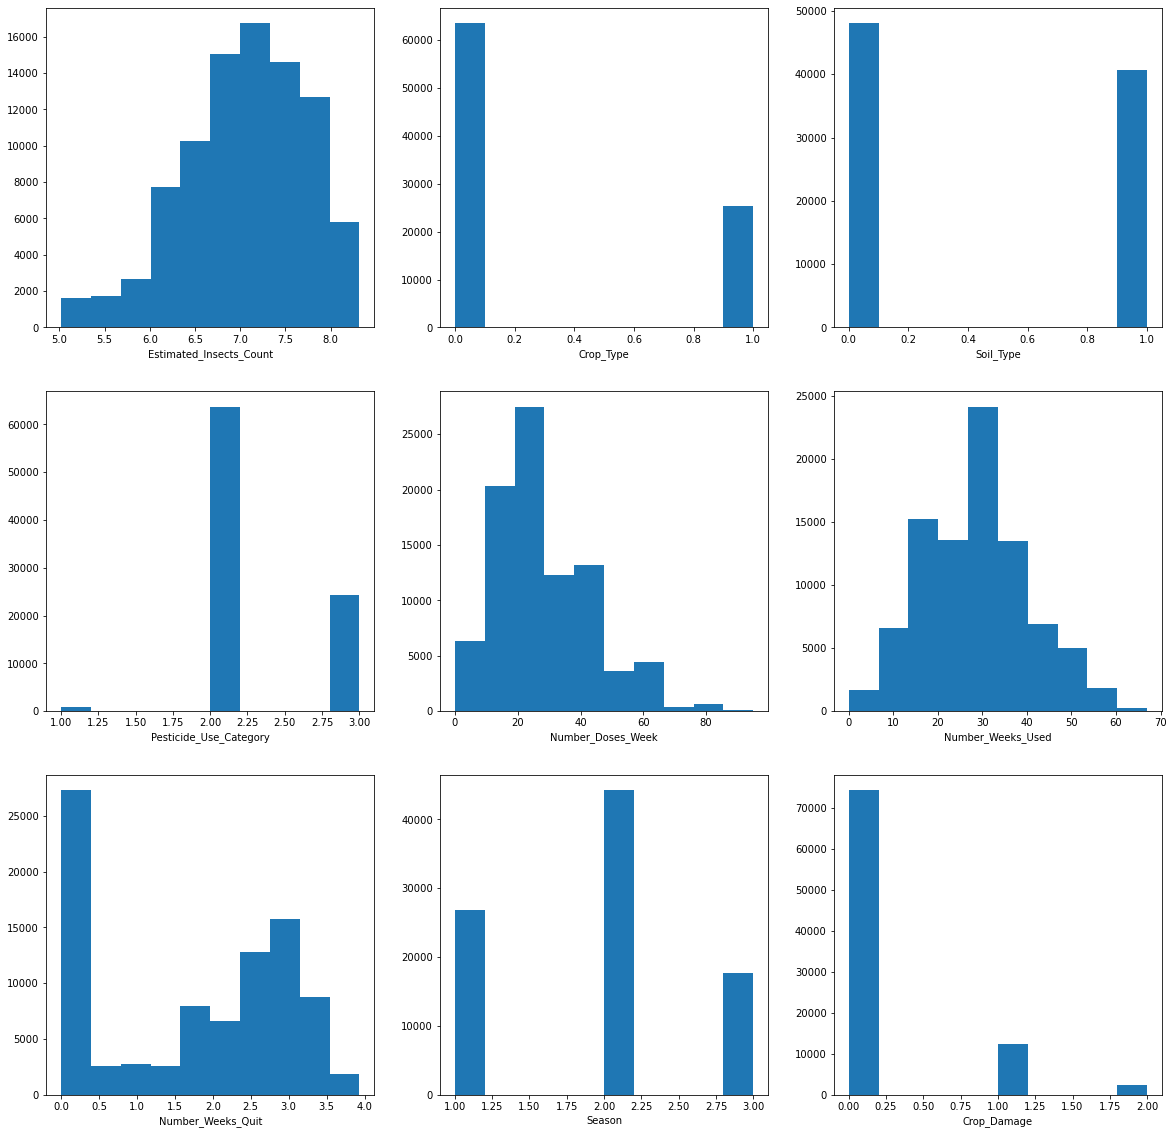

In [6]:
fig, ax = plt.subplots(3, 3, figsize = (20, 20))
for col, axis in zip(cols, ax.flatten()):
    axis.hist(train[col])
    axis.set_xlabel(col)

In [7]:
drop = ['ID']

X = train.drop(['Crop_Damage']+drop, axis = 1)
y = train['Crop_Damage']


## Use skopt to tune models - One possible approach

#### We will be using skopt to tune Lightgbm

In [8]:
def optimize_sk(params, param_names, X, y, scoring, estimator, cv = model_selection.StratifiedKFold(n_splits = 5)):
    '''params: list of param values
    param_names: param names
    x: training exogs
    y: training endogs
    return: negative metric after k fold validation'''

    params = dict(zip(param_names, params))

    # Initialize the model
    model = estimator(**params)

    kf = cv

    scores = []
    for train_index, test_index in kf.split(X, y):
        # Split Data
        X_train, y_train = np.array(X)[train_index, :], y[train_index]
        X_test, y_test = np.array(X)[test_index, :], y[test_index]

        # Fit model
        model.fit(X_train, y_train)

        # Evaluate model
        preds = model.predict(X_test)
        scores.append(scoring(y_test, preds))

    return -np.mean(scores)

# Scoring
def f1_score(y_true, y_pred):
    return metrics.f1_score(y_true, y_pred, average = 'macro')

def accuracy(y_true, y_pred):
    return metrics.accuracy_score(y_true, y_pred)

# Parameter Space
param_space = [
    space.Integer(500, 2500, name = 'n_estimators'),
    space.Integer(2, 10, name = 'max_depth'),
    space.Real(0, 1, name = 'feature_fraction'),
    space.Integer(2, 25, name = 'min_data_in_leaf'),
    space.Real(.001, .4, name = 'learning_rate')
]

# Param names
names = ['n_estimators', 'max_depth', 'feature_fraction', 'min_data_in_leaf', 'learning_rate']

cat_cols = ['Crop_Type', 'Soil_Type', 'Pesticide_Use_Category','Season']

# Define objective - reformat it in terms of what is required for skopt
objective_optimization = partial(optimize_sk, param_names = names, X = X, y = y, 
                                scoring = accuracy, estimator = partial(lgb.LGBMClassifier,
                                                                    cat_columns = cat_cols))

# Perform Optimization
#gbrt_minimize, dummy_minimize, forest_minimize
skopt_optimization = dummy_minimize(func = objective_optimization, 
                                dimensions = param_space, n_calls = 10,  
                                x0 = None, y0 = None, random_state = 10, 
                                verbose = 10)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 87.5600
Function value obtained: -0.8360
Current minimum: -0.8360
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 34.8878
Function value obtained: -0.8421
Current minimum: -0.8421
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 46.2661
Function value obtained: -0.8402
Current minimum: -0.8421
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 35.5500
Function value obtained: -0.8349
Current minimum: -0.8421
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 58.7293
Function value obtained: -0.8468
Current minimum: -0.8468
Iteration No: 6 star

In [9]:
model = lgb.LGBMClassifier(**dict(zip(names, skopt_optimization.x))).fit(X, y)


## The best results came after hand-tuning the models

#### Create Hand tuned Ensemble model

In [10]:
cat_cols = ['Crop_Type', 'Soil_Type', 'Pesticide_Use_Category','Season']
model_cb = cb.CatBoostClassifier(cat_features = cat_cols, verbose = False)

model_lgb = lgb.LGBMClassifier(n_estimators = 1000, min_samples_in_leaf = 10, learning_rate = .02, 
                          feature_fraction = .8, max_depth = 8)

# Soft Voting Classifier
model_voting = ensemble.VotingClassifier([('catboost', model_cb), ('lightgbm', model_lgb)], 
                                         voting = 'soft').fit(X, y)


In [11]:
pred = pd.DataFrame()
pred['ID'] = test['ID'].values
pred['Crop_Damage'] = model_voting.predict(test.drop(drop, axis = 1))
pred.to_csv('SubAgro.csv', index = None)